In [12]:
import torch
from torch import nn, optim
import torchvision
import torch.nn.functional as F

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv = nn.Sequential(
            # 32*32*32
            nn.Conv2d(3, 32, 3, 1), # in_channels, out_channels, kernel_size, stride, padding
            nn.MaxPool2d(2, 2), # kernel_size, stride
            nn.ReLU(),            
            # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增加输出通道数
            # 64*14*14
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
        # 连续3个卷积层，且使用更小的卷积窗口。除了最后的卷积层外，进一步 增加了输出通道数。
        # 前两个卷积层后不使用池化层来减小输入的⾼和宽 
            # 128*7*7
            nn.Conv2d(64, 128, 3, 1, 1), 
            # 256*7*7
            nn.Conv2d(128, 256, 3, 1, 1), 
            # 256*7*7
            nn.Conv2d(256, 256, 3, 1, 1), 
            # 256*3*3
            nn.MaxPool2d(2, 2),
            nn.ReLU()
        )
        # 这里全连接层的输出个数 ALexNet中的数倍。使用dropout来缓解过拟合。
        self.fc = nn.Sequential(
        # 输出层，10分类
            nn.Linear(256*3*3, 1024),
            nn.Linear(1024, 512),
            nn.Linear(512, 10),
        )
    def forward(self, img):
        feature = self.conv(img)
        output = self.fc(feature.view(img.shape[0], -1))
        return output







In [41]:
# 超参数定义
EPOCH = 15               # 训练epoch次数
BATCH_SIZE = 64         # 批训练的数量
LR = 0.001              # 学习率
DOWNLOAD_CIFAR = True  # 设置True 可以自动下载数据




In [21]:
# Cifar-10 数据集调用
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

train_data = torchvision.datasets.CIFAR10(
    root='./Cifar-10',  # 保存或者提取位置
    train=True,  # this is training data
    transform=torchvision.transforms.ToTensor(),  # 转换 PIL.Image or numpy.ndarray 成
    # torch.FloatTensor (C x H x W), 训练的时候 normalize 成 [0.0, 1.0] 区间
    download=DOWNLOAD_CIFAR,  # 没下载就下载, 下载了就不用再下了
)

test_data = torchvision.datasets.CIFAR10(root='./Cifar-10',
                        train=False,                         # 测试集
                        transform=transforms.ToTensor()
                        )



Files already downloaded and verified


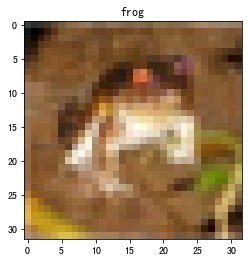

In [50]:
plt.show()
for images, labels in train_data:
    images = images.numpy().transpose(1, 2, 0)  # 把channel那一维放到最后
    plt.title(str(classes[labels]))
    plt.imshow(images)
    plt.pause(1)
    break


In [48]:
# plot其中一张手写数字图片
print('训练集大小：', train_data)     # 查看训练集数据大小，60000张32*32的图片 (60000, 32, 32)
# print('训练集标签个数：', train_data.train_labels.size())   # 查看训练集标签大小，60000个标签 (60000)
# plt.imshow(train_data[0], cmap='gray') # plot 训练集第一张图片
# plt.title('%i' % train_data.train_labels[0])              # 图片名称，显示真实标签，%i %d十进制整数，有区别，深入请查阅资料
plt.show()                                                # show


训练集大小： Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./Cifar-10
    Split: Train
    StandardTransform
Transform: ToTensor()


In [42]:
# 使用DataLoader进行分批
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)

# AlexNet Model
model = AlexNet()
#损失函数:这里用交叉熵
criterion = nn.CrossEntropyLoss()
#优化器 这里用SGD
# optimizer = optim.Adam(model.parameters(), lr=1e-3)

#优化方式为mini-batch momentum-SGD，并采用L2正则化（权重衰减）
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=1e-3) 


# device : GPU or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

AlexNet(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=2304, out_features=1024, bias=True)
    (1): Linear(in_features=1024, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [49]:
# 训练
for epoch in range(EPOCH):
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # 前向传播
        outputs = model(inputs)
        # 计算损失函数
        loss = criterion(outputs, labels)
        # 清空上一轮梯度
        optimizer.zero_grad()
        # 反向传播
        loss.backward()
        # 参数更新
        optimizer.step()

    print('epoch{} loss:{:.4f}'.format(epoch+1, loss.item()))

print("Finished Traning")




epoch1 loss:2.1631
epoch2 loss:1.7325
epoch3 loss:1.8003
epoch4 loss:2.0901
epoch5 loss:1.5666
epoch6 loss:1.7478
epoch7 loss:1.5580
epoch8 loss:1.4064
epoch9 loss:1.2081
epoch10 loss:1.2806
epoch11 loss:0.9066
epoch12 loss:1.1185
epoch13 loss:1.6866
epoch14 loss:1.1166
epoch15 loss:1.0673
Finished Traning


In [55]:
#保存训练模型
torch.save(model, 'cifar_alexnet.pt')
model = torch.load('cifar_alexnet.pt')



In [51]:
#保存训练模型
torch.save(model, 'cifar_alexnet_SGD.pt')
model = torch.load('cifar_alexnet_SGD.pt')

In [56]:
# 测试
model.eval()
correct = 0
total = 0

for data in test_loader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    # 前向传播
    out = model(images)
    _, predicted = torch.max(out.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

#输出识别准确率
print('10000测试图像 准确率:{:.4f}%'.format(100 * correct / total)) 

10000测试图像 准确率:59.7100%
